In [1]:
# =============================================================================
# NOTEBOOK 03: SALES FORECASTING
# =============================================================================
# Project: Retail Predictive Analytics Suite
# Author: [Your Name]
# Date: 2024
# Objective: Forecast future sales using ARIMA and Prophet models
# =============================================================================

# =============================================================================
# CELL 1: IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Time Series Libraries
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prophet
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Model Persistence
import joblib

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Libraries imported successfully
Analysis Date: 2026-02-11 13:11


In [2]:
# =============================================================================
# CELL 2: LOAD AND PREPARE DATA
# =============================================================================

# Load cleaned data
df = pd.read_csv('../data/processed/clean_retail.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("=" * 60)
print("DATA LOADED")
print("=" * 60)
print(f"Total Records: {len(df):,}")
print(f"Date Range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")

# Create daily time series
daily_sales = df.groupby(df['InvoiceDate'].dt.date).agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'Invoice': 'nunique'
}).reset_index()

daily_sales.columns = ['Date', 'Revenue', 'Quantity', 'Transactions']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales = daily_sales.set_index('Date')
daily_sales = daily_sales.sort_index()

# Create monthly time series
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M')).agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'Invoice': 'nunique'
}).reset_index()

monthly_sales.columns = ['Month', 'Revenue', 'Quantity', 'Transactions']
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()
monthly_sales = monthly_sales.set_index('Month')

print(f"\nDaily Series: {len(daily_sales)} days")
print(f"Monthly Series: {len(monthly_sales)} months")

# Display sample
print("\nMonthly Sales Sample:")
display(monthly_sales.head(10))

DATA LOADED
Total Records: 779,425
Date Range: 2009-12-01 to 2011-12-09

Daily Series: 604 days
Monthly Series: 25 months

Monthly Sales Sample:


,Revenue,Quantity,Transactions
Month,,,
2009-12-01,683504.010,398660,1512
2010-01-01,555802.672,370082,1011
2010-02-01,504558.956,371861,1104
2010-03-01,696978.471,502100,1524
2010-04-01,591982.002,350587,1329
2010-05-01,597833.380,384960,1377
2010-06-01,636371.130,389872,1497
2010-07-01,589736.170,324632,1381
2010-08-01,602224.600,452542,1293


TIME SERIES VISUALIZATION


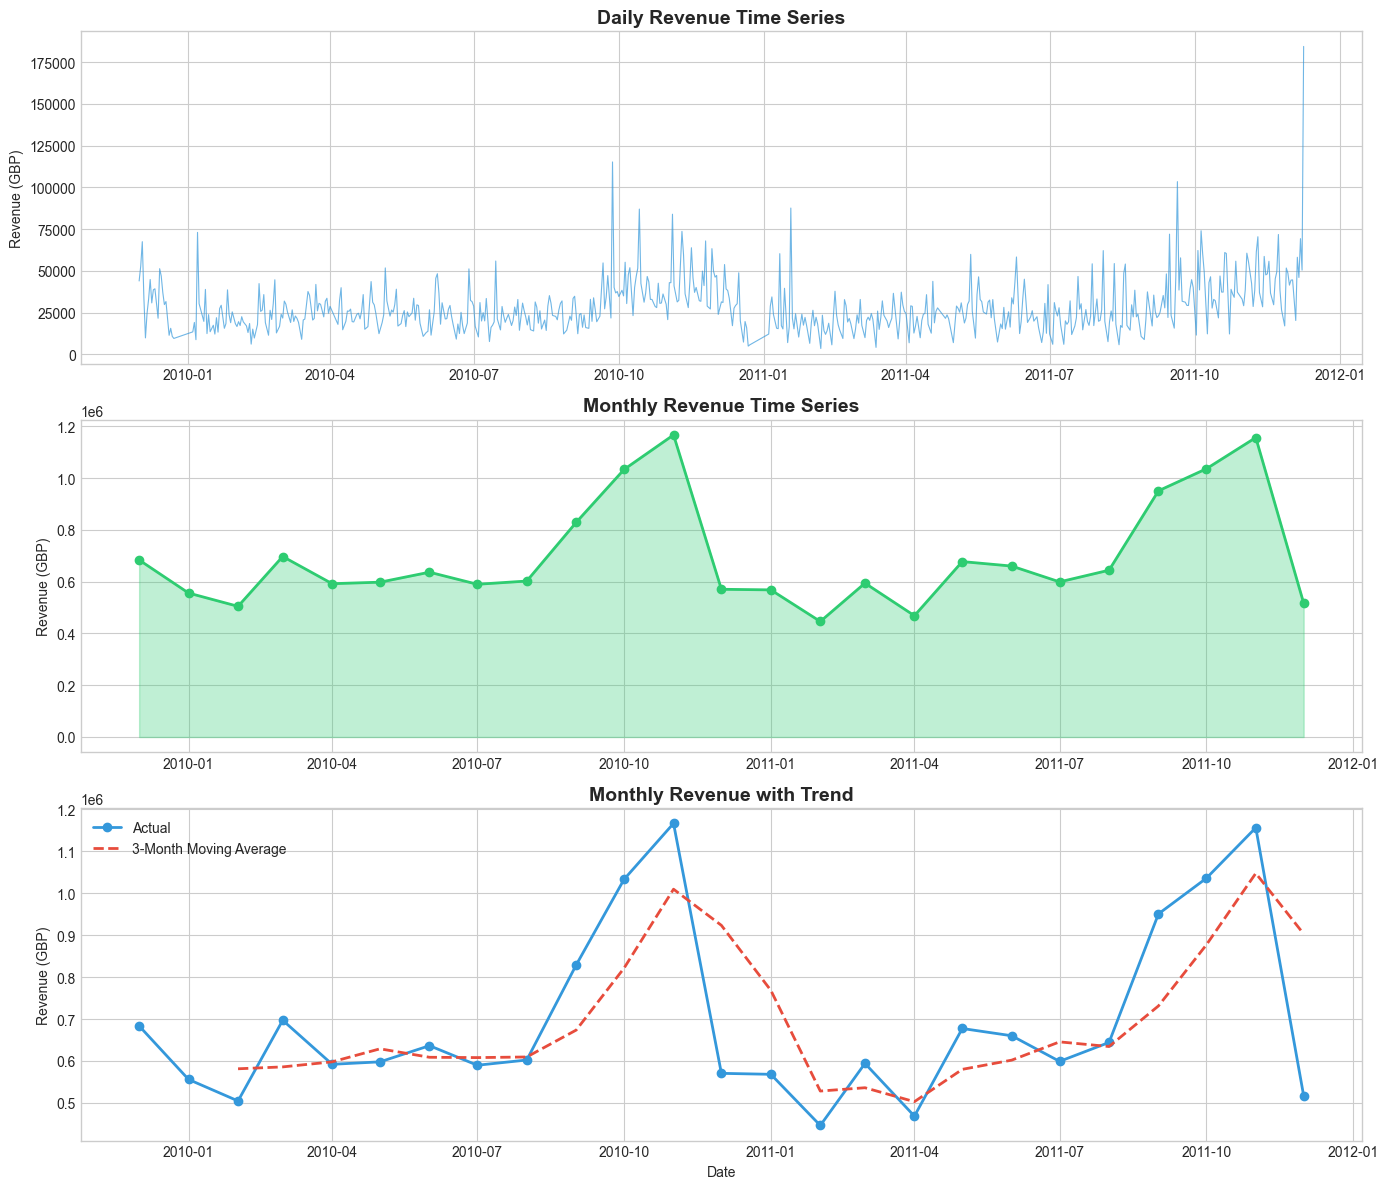


Plot saved: outputs/forecasting/time_series_overview.png


In [3]:
# =============================================================================
# CELL 3: TIME SERIES VISUALIZATION
# =============================================================================

print("=" * 60)
print("TIME SERIES VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Daily Revenue
ax1 = axes[0]
ax1.plot(daily_sales.index, daily_sales['Revenue'], color='#3498db', alpha=0.7, linewidth=0.8)
ax1.set_title('Daily Revenue Time Series', fontsize=14, fontweight='bold')
ax1.set_ylabel('Revenue (GBP)')
ax1.set_xlabel('')

# Plot 2: Monthly Revenue
ax2 = axes[1]
ax2.plot(monthly_sales.index, monthly_sales['Revenue'], marker='o', 
         color='#2ecc71', linewidth=2, markersize=6)
ax2.fill_between(monthly_sales.index, monthly_sales['Revenue'], alpha=0.3, color='#2ecc71')
ax2.set_title('Monthly Revenue Time Series', fontsize=14, fontweight='bold')
ax2.set_ylabel('Revenue (GBP)')
ax2.set_xlabel('')

# Plot 3: Monthly Revenue with Trend
ax3 = axes[2]
ax3.plot(monthly_sales.index, monthly_sales['Revenue'], marker='o', 
         color='#3498db', linewidth=2, label='Actual')

# Add rolling mean
rolling_mean = monthly_sales['Revenue'].rolling(window=3).mean()
ax3.plot(monthly_sales.index, rolling_mean, color='#e74c3c', 
         linewidth=2, linestyle='--', label='3-Month Moving Average')

ax3.set_title('Monthly Revenue with Trend', fontsize=14, fontweight='bold')
ax3.set_ylabel('Revenue (GBP)')
ax3.set_xlabel('Date')
ax3.legend()

plt.tight_layout()
plt.savefig('../outputs/forecasting/time_series_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/time_series_overview.png")

SEASONAL DECOMPOSITION


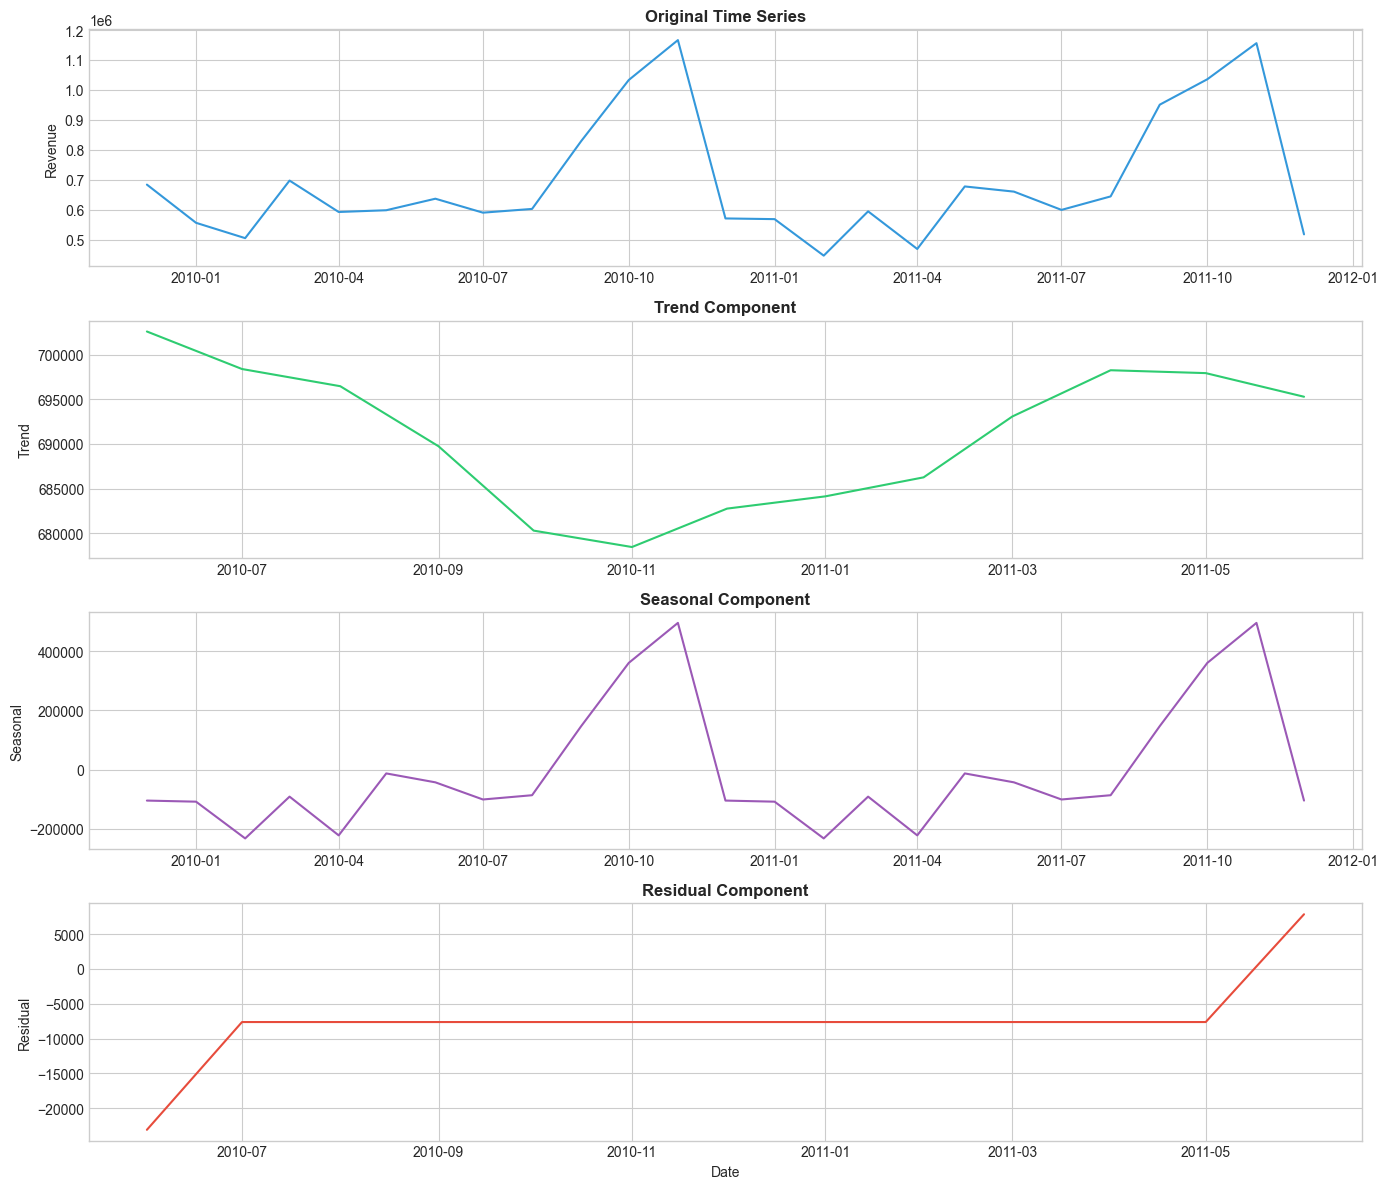


Plot saved: outputs/forecasting/seasonal_decomposition.png


In [4]:
# =============================================================================
# CELL 4: SEASONAL DECOMPOSITION
# =============================================================================

print("=" * 60)
print("SEASONAL DECOMPOSITION")
print("=" * 60)

# Use monthly data for decomposition
# Need at least 2 complete cycles, so use additive model
decomposition = seasonal_decompose(monthly_sales['Revenue'], model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original
axes[0].plot(monthly_sales.index, monthly_sales['Revenue'], color='#3498db')
axes[0].set_title('Original Time Series', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Revenue')

# Trend
axes[1].plot(monthly_sales.index, decomposition.trend, color='#2ecc71')
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend')

# Seasonal
axes[2].plot(monthly_sales.index, decomposition.seasonal, color='#9b59b6')
axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonal')

# Residual
axes[3].plot(monthly_sales.index, decomposition.resid, color='#e74c3c')
axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.savefig('../outputs/forecasting/seasonal_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/seasonal_decomposition.png")

In [5]:
# =============================================================================
# CELL 5: STATIONARITY TEST (ADF TEST)
# =============================================================================

print("=" * 60)
print("STATIONARITY TEST - AUGMENTED DICKEY-FULLER")
print("=" * 60)

def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{title}")
    print("-" * 50)
    print(f"ADF Statistic:     {result[0]:.6f}")
    print(f"p-value:           {result[1]:.6f}")
    print(f"Lags Used:         {result[2]}")
    print(f"Observations:      {result[3]}")
    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print("\nConclusion: Series is STATIONARY (reject null hypothesis)")
        return True
    else:
        print("\nConclusion: Series is NON-STATIONARY (fail to reject null hypothesis)")
        return False

# Test original series
is_stationary = adf_test(monthly_sales['Revenue'], 'Original Monthly Revenue')

# If not stationary, apply differencing
if not is_stationary:
    print("\n" + "=" * 60)
    print("APPLYING DIFFERENCING")
    print("=" * 60)
    
    # First differencing
    diff_1 = monthly_sales['Revenue'].diff().dropna()
    is_stationary_diff1 = adf_test(diff_1, 'First Differenced Series')
    
    # Visualize differencing
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    axes[0].plot(monthly_sales.index, monthly_sales['Revenue'], color='#3498db')
    axes[0].set_title('Original Series', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Revenue')
    
    axes[1].plot(diff_1.index, diff_1, color='#2ecc71')
    axes[1].set_title('First Differenced Series (d=1)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Differenced Revenue')
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('../outputs/forecasting/differencing.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nPlot saved: outputs/forecasting/differencing.png")

STATIONARITY TEST - AUGMENTED DICKEY-FULLER

Original Monthly Revenue
--------------------------------------------------
ADF Statistic:     -3.372171
p-value:           0.011945
Lags Used:         9
Observations:      15

Critical Values:
   1%: -3.9644
   5%: -3.0849
   10%: -2.6818

Conclusion: Series is STATIONARY (reject null hypothesis)


ACF AND PACF ANALYSIS
Number of observations (original): 25
Number of observations (differenced): 24
Using lags (original): 11
Using lags (differenced): 11


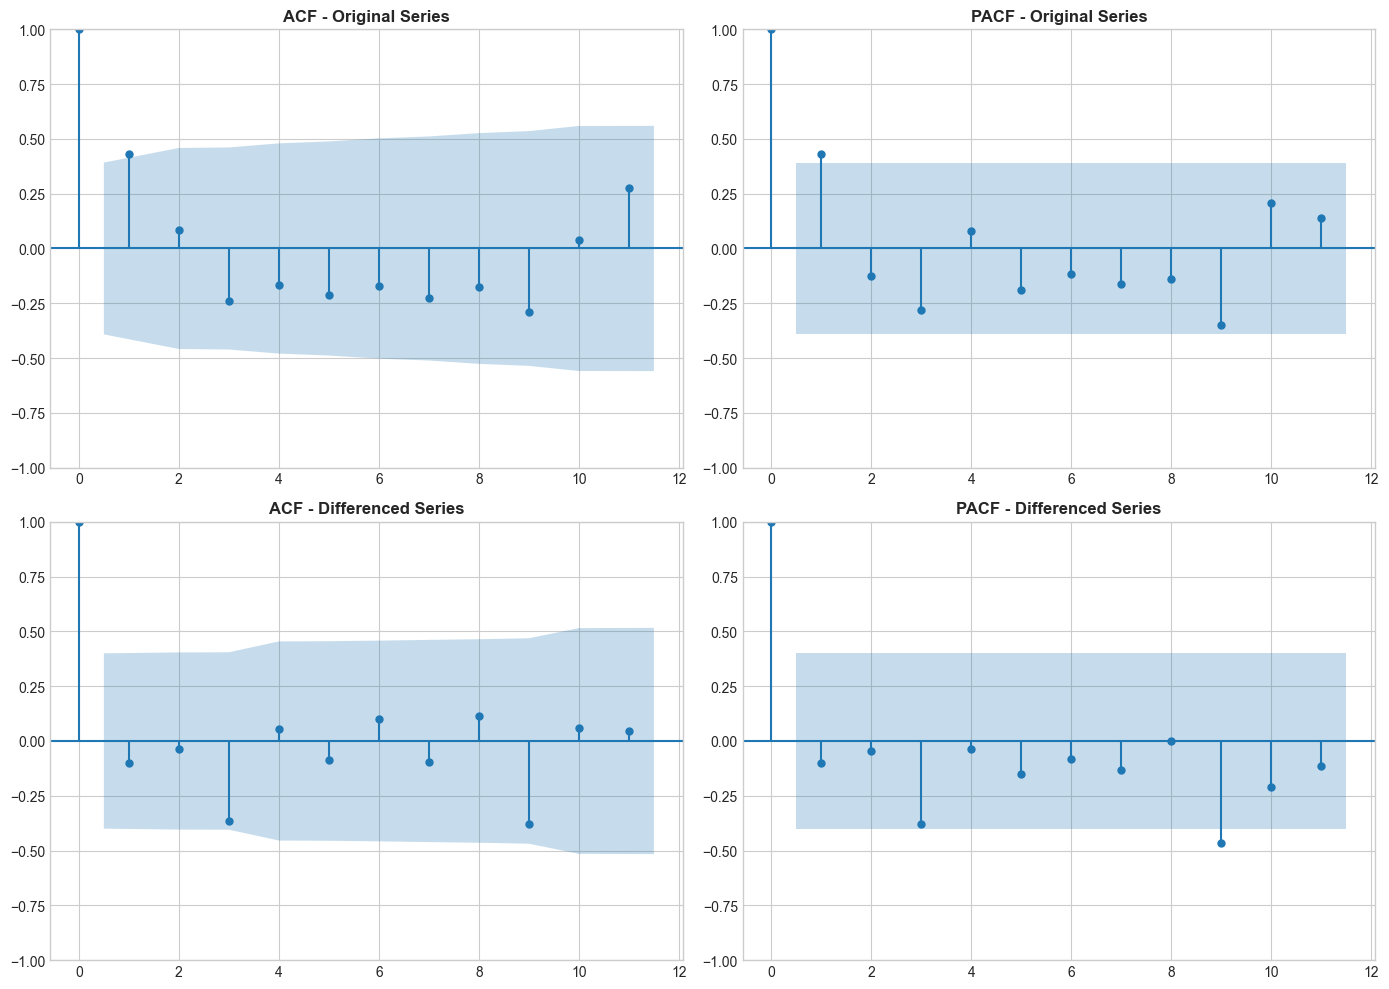


Plot saved: ../outputs/forecasting/acf_pacf.png

ACF/PACF INTERPRETATION GUIDE:
-----------------------------------------
ARIMA(p, d, q):

d (Differencing):
- If original ACF decays slowly → Non-stationary → d = 1
- If differenced ACF looks stable → Stationary

p (AR order):
- Look at PACF (differenced series)
- Count significant spikes before cutoff

q (MA order):
- Look at ACF (differenced series)
- Count significant spikes before cutoff

General Rules:
- Sharp cutoff in PACF → AR model
- Sharp cutoff in ACF → MA model
- Gradual decay in both → ARMA model

For small datasets (< 36 observations):
- Keep p and q small (0–3)
- Avoid overfitting



In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("=" * 60)
print("ACF AND PACF ANALYSIS")
print("=" * 60)

# -----------------------------
# Prepare Data
# -----------------------------
revenue_series = monthly_sales['Revenue'].dropna()
diff_series = revenue_series.diff().dropna()

# -----------------------------
# Safe Lag Calculation
# PACF requires nlags < 50% of sample size
# -----------------------------
n_obs_original = len(revenue_series)
n_obs_diff = len(diff_series)

safe_lags_original = min(20, n_obs_original // 2 - 1)
safe_lags_diff = min(20, n_obs_diff // 2 - 1)

print(f"Number of observations (original): {n_obs_original}")
print(f"Number of observations (differenced): {n_obs_diff}")
print(f"Using lags (original): {safe_lags_original}")
print(f"Using lags (differenced): {safe_lags_diff}")

# -----------------------------
# Plot ACF & PACF
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---- Original Series ----
plot_acf(revenue_series, ax=axes[0, 0], lags=safe_lags_original)
axes[0, 0].set_title('ACF - Original Series', fontsize=12, fontweight='bold')

plot_pacf(revenue_series, ax=axes[0, 1], 
          lags=safe_lags_original, method='ywm')
axes[0, 1].set_title('PACF - Original Series', fontsize=12, fontweight='bold')

# ---- Differenced Series ----
plot_acf(diff_series, ax=axes[1, 0], lags=safe_lags_diff)
axes[1, 0].set_title('ACF - Differenced Series', fontsize=12, fontweight='bold')

plot_pacf(diff_series, ax=axes[1, 1], 
          lags=safe_lags_diff, method='ywm')
axes[1, 1].set_title('PACF - Differenced Series', fontsize=12, fontweight='bold')

plt.tight_layout()

# -----------------------------
# Save Plot
# -----------------------------
output_path = '../outputs/forecasting/acf_pacf.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved: {output_path}")

# -----------------------------
# Interpretation Guide
# -----------------------------
print("""
ACF/PACF INTERPRETATION GUIDE:
-----------------------------------------
ARIMA(p, d, q):

d (Differencing):
- If original ACF decays slowly → Non-stationary → d = 1
- If differenced ACF looks stable → Stationary

p (AR order):
- Look at PACF (differenced series)
- Count significant spikes before cutoff

q (MA order):
- Look at ACF (differenced series)
- Count significant spikes before cutoff

General Rules:
- Sharp cutoff in PACF → AR model
- Sharp cutoff in ACF → MA model
- Gradual decay in both → ARMA model

For small datasets (< 36 observations):
- Keep p and q small (0–3)
- Avoid overfitting
""")


TRAIN-TEST SPLIT
Total Observations: 25
Training Set: 20 months (2009-12 to 2011-07)
Test Set: 5 months (2011-08 to 2011-12)


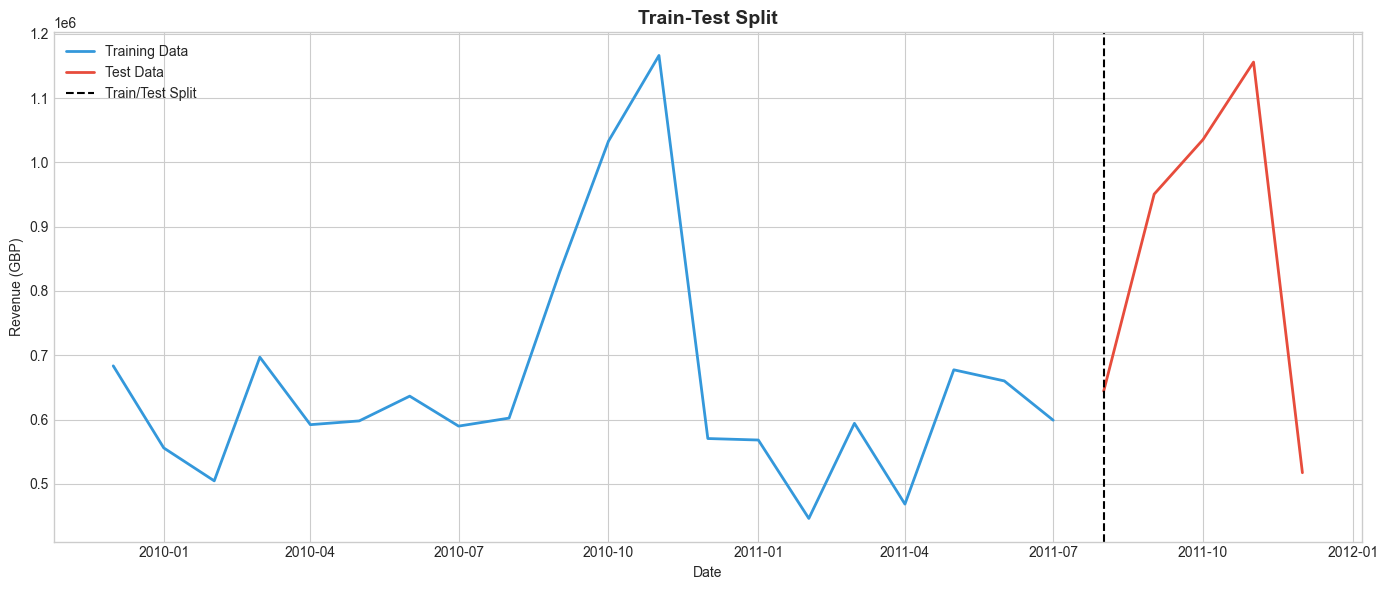


Plot saved: outputs/forecasting/train_test_split.png


In [8]:
# =============================================================================
# CELL 7: TRAIN-TEST SPLIT
# =============================================================================

print("=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

# Use 80% for training, 20% for testing
train_size = int(len(monthly_sales) * 0.8)

train = monthly_sales.iloc[:train_size]
test = monthly_sales.iloc[train_size:]

print(f"Total Observations: {len(monthly_sales)}")
print(f"Training Set: {len(train)} months ({train.index.min().strftime('%Y-%m')} to {train.index.max().strftime('%Y-%m')})")
print(f"Test Set: {len(test)} months ({test.index.min().strftime('%Y-%m')} to {test.index.max().strftime('%Y-%m')})")

# Visualize split
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train.index, train['Revenue'], color='#3498db', label='Training Data', linewidth=2)
ax.plot(test.index, test['Revenue'], color='#e74c3c', label='Test Data', linewidth=2)
ax.axvline(x=test.index[0], color='black', linestyle='--', label='Train/Test Split')

ax.set_title('Train-Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (GBP)')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/forecasting/train_test_split.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/train_test_split.png")

In [9]:
# =============================================================================
# CELL 8: ARIMA MODEL - GRID SEARCH
# =============================================================================

print("=" * 60)
print("ARIMA MODEL - PARAMETER OPTIMIZATION")
print("=" * 60)

# Define parameter ranges
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

# Store results
arima_results = []

print("Running Grid Search (this may take a few minutes)...")
print("-" * 60)

best_aic = float('inf')
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train['Revenue'], order=(p, d, q))
                fitted = model.fit()
                aic = fitted.aic
                
                arima_results.append({
                    'Order': (p, d, q),
                    'AIC': aic
                })
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    print(f"New Best: ARIMA{(p, d, q)} - AIC: {aic:.2f}")
                    
            except Exception as e:
                continue

print("-" * 60)
print(f"\nBest Model: ARIMA{best_order}")
print(f"Best AIC: {best_aic:.2f}")

# Display top 10 models
arima_df = pd.DataFrame(arima_results)
arima_df = arima_df.sort_values('AIC').head(10)
print("\nTop 10 Models by AIC:")
display(arima_df)

ARIMA MODEL - PARAMETER OPTIMIZATION
Running Grid Search (this may take a few minutes)...
------------------------------------------------------------
New Best: ARIMA(0, 0, 0) - AIC: 583.66
New Best: ARIMA(0, 0, 1) - AIC: 541.16
New Best: ARIMA(0, 1, 0) - AIC: 516.43
------------------------------------------------------------

Best Model: ARIMA(0, 1, 0)
Best AIC: 516.43

Top 10 Models by AIC:


,Order,AIC
4,"(0, 1, 0)",516.429399
12,"(1, 1, 0)",517.526471
5,"(0, 1, 1)",517.560970
13,"(1, 1, 1)",518.754707
20,"(2, 1, 0)",519.439051
21,"(2, 1, 1)",520.355861
6,"(0, 1, 2)",520.737460
28,"(3, 1, 0)",520.931005
29,"(3, 1, 1)",522.177974
14,"(1, 1, 2)",522.403569


In [10]:
# =============================================================================
# CELL 9: FIT BEST ARIMA MODEL
# =============================================================================

print("=" * 60)
print("FITTING BEST ARIMA MODEL")
print("=" * 60)

# Fit the best model
arima_model = ARIMA(train['Revenue'], order=best_order)
arima_fitted = arima_model.fit()

# Model summary
print(f"\nARIMA{best_order} Model Summary:")
print("=" * 60)
print(arima_fitted.summary())

# Save model
joblib.dump(arima_fitted, '../models/arima_model.pkl')
print("\nModel saved: models/arima_model.pkl")

FITTING BEST ARIMA MODEL

ARIMA(0, 1, 0) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                   20
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -257.215
Date:                Wed, 11 Feb 2026   AIC                            516.429
Time:                        13:15:46   BIC                            517.374
Sample:                    12-01-2009   HQIC                           516.589
                         - 07-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.186e+10   6.01e+09      5.304      0.000    2.01e+10    4.36e+10
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):             

ARIMA FORECAST AND EVALUATION

ARIMA(0, 1, 0) PERFORMANCE METRICS
-----------------------------------------
MAE (Mean Absolute Error):     294,498.43 GBP
RMSE (Root Mean Square Error): 355,988.00 GBP
MAPE (Mean Abs % Error):       30.03%



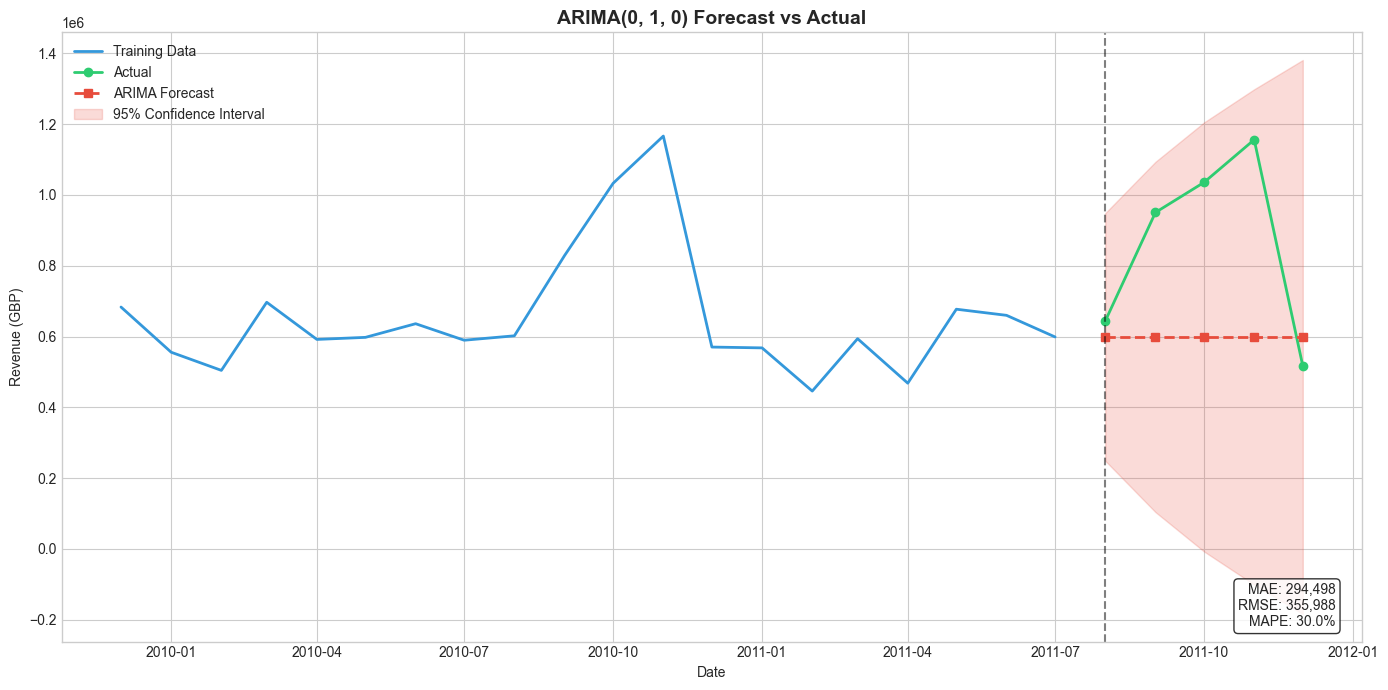


Plot saved: outputs/forecasting/arima_forecast.png

ARIMA Predictions vs Actual:


,Date,Actual,Predicted,Lower_CI,Upper_CI
0,2011-08-01,644051.040,598962.901,249103.186868,9.488226e+05
1,2011-09-01,950690.202,598962.901,104186.548347,1.093739e+06
2,2011-10-01,1035642.450,598962.901,-7011.899397,1.204938e+06
3,2011-11-01,1156205.610,598962.901,-100756.527263,1.298682e+06
4,2011-12-01,517208.440,598962.901,-183347.202387,1.381273e+06


In [11]:
# =============================================================================
# CELL 10: ARIMA FORECAST AND EVALUATION
# =============================================================================

print("=" * 60)
print("ARIMA FORECAST AND EVALUATION")
print("=" * 60)

# Forecast on test period
forecast_steps = len(test)
arima_forecast = arima_fitted.forecast(steps=forecast_steps)
arima_conf_int = arima_fitted.get_forecast(steps=forecast_steps).conf_int()

# Create forecast dataframe
arima_predictions = pd.DataFrame({
    'Date': test.index,
    'Actual': test['Revenue'].values,
    'Predicted': arima_forecast.values,
    'Lower_CI': arima_conf_int.iloc[:, 0].values,
    'Upper_CI': arima_conf_int.iloc[:, 1].values
})

# Calculate metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = calculate_metrics(
    arima_predictions['Actual'], 
    arima_predictions['Predicted']
)

print(f"""
ARIMA{best_order} PERFORMANCE METRICS
-----------------------------------------
MAE (Mean Absolute Error):     {arima_mae:,.2f} GBP
RMSE (Root Mean Square Error): {arima_rmse:,.2f} GBP
MAPE (Mean Abs % Error):       {arima_mape:.2f}%
""")

# Visualize forecast
fig, ax = plt.subplots(figsize=(14, 7))

# Training data
ax.plot(train.index, train['Revenue'], color='#3498db', 
        label='Training Data', linewidth=2)

# Actual test data
ax.plot(test.index, test['Revenue'], color='#2ecc71', 
        label='Actual', linewidth=2, marker='o')

# Predictions
ax.plot(test.index, arima_predictions['Predicted'], color='#e74c3c', 
        label='ARIMA Forecast', linewidth=2, linestyle='--', marker='s')

# Confidence interval
ax.fill_between(test.index, 
                arima_predictions['Lower_CI'], 
                arima_predictions['Upper_CI'], 
                color='#e74c3c', alpha=0.2, label='95% Confidence Interval')

ax.axvline(x=test.index[0], color='black', linestyle='--', alpha=0.5)
ax.set_title(f'ARIMA{best_order} Forecast vs Actual', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (GBP)')
ax.legend(loc='upper left')

# Add metrics annotation
metrics_text = f'MAE: {arima_mae:,.0f}\nRMSE: {arima_rmse:,.0f}\nMAPE: {arima_mape:.1f}%'
ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('../outputs/forecasting/arima_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/arima_forecast.png")

# Display predictions
print("\nARIMA Predictions vs Actual:")
display(arima_predictions)

In [12]:
# =============================================================================
# CELL 11: PROPHET MODEL - DATA PREPARATION
# =============================================================================

print("=" * 60)
print("PROPHET MODEL - DATA PREPARATION")
print("=" * 60)

# Prophet requires specific column names: ds (date) and y (target)
prophet_train = train.reset_index()
prophet_train.columns = ['ds', 'y', 'Quantity', 'Transactions']
prophet_train = prophet_train[['ds', 'y']]

prophet_test = test.reset_index()
prophet_test.columns = ['ds', 'y', 'Quantity', 'Transactions']
prophet_test = prophet_test[['ds', 'y']]

print("Training Data for Prophet:")
display(prophet_train.head())
print(f"\nTraining samples: {len(prophet_train)}")
print(f"Test samples: {len(prophet_test)}")

PROPHET MODEL - DATA PREPARATION
Training Data for Prophet:


,ds,y
0,2009-12-01,683504.010
1,2010-01-01,555802.672
2,2010-02-01,504558.956
3,2010-03-01,696978.471
4,2010-04-01,591982.002



Training samples: 20
Test samples: 5


In [13]:
# =============================================================================
# CELL 12: PROPHET MODEL - TRAINING
# =============================================================================

print("=" * 60)
print("PROPHET MODEL - TRAINING")
print("=" * 60)

# Initialize Prophet model with custom parameters
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

# Fit the model
prophet_model.fit(prophet_train)

print("Prophet model trained successfully")
print(f"Seasonality Mode: multiplicative")
print(f"Yearly Seasonality: True")

# Save model
joblib.dump(prophet_model, '../models/prophet_model.pkl')
print("\nModel saved: models/prophet_model.pkl")

13:16:06 - cmdstanpy - INFO - Chain [1] start processing


PROPHET MODEL - TRAINING


13:16:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully
Seasonality Mode: multiplicative
Yearly Seasonality: True

Model saved: models/prophet_model.pkl


PROPHET FORECAST AND EVALUATION

PROPHET PERFORMANCE METRICS
-----------------------------------------
MAE (Mean Absolute Error):     186,412.39 GBP
RMSE (Root Mean Square Error): 214,348.07 GBP
MAPE (Mean Abs % Error):       22.08%



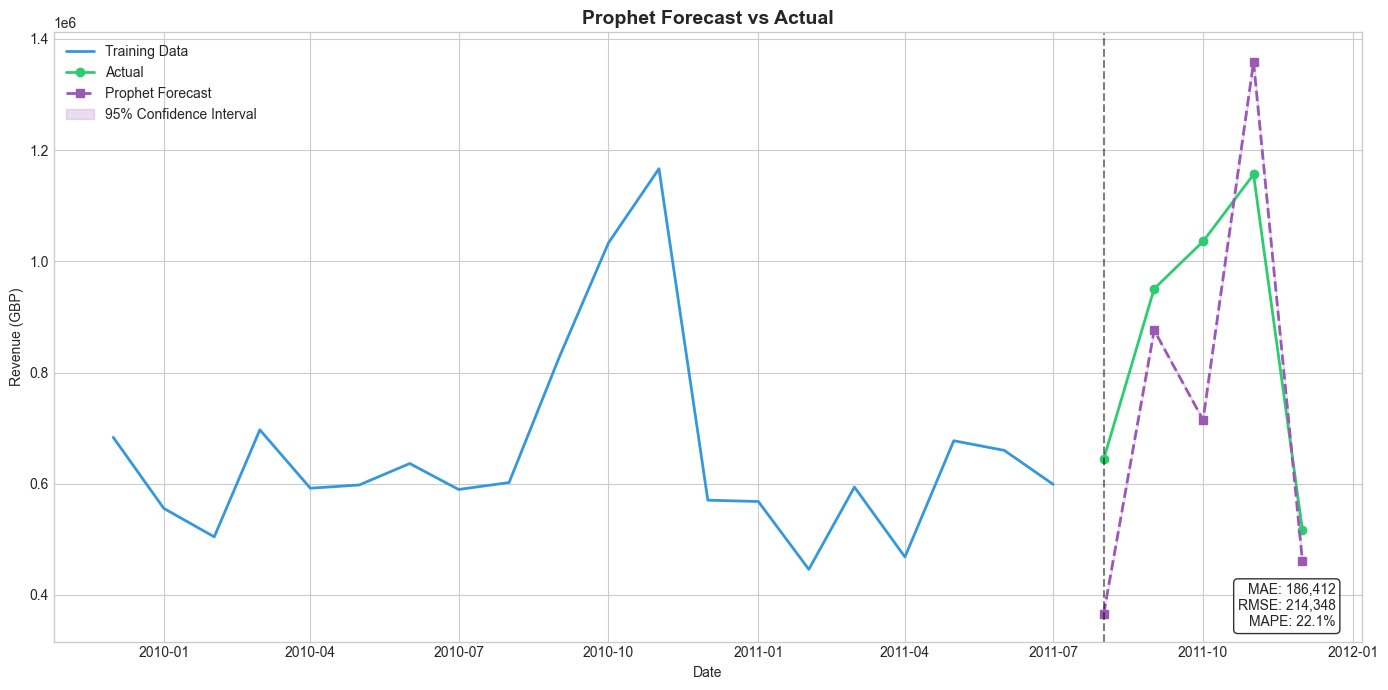


Plot saved: outputs/forecasting/prophet_forecast.png

Prophet Predictions vs Actual:


,Date,Actual,Predicted,Lower_CI,Upper_CI
0,2011-08-01,644051.040,3.661383e+05,3.660177e+05,3.662426e+05
1,2011-09-01,950690.202,8.759905e+05,8.751005e+05,8.767869e+05
2,2011-10-01,1035642.450,7.149076e+05,7.136411e+05,7.162091e+05
3,2011-11-01,1156205.610,1.358269e+06,1.354579e+06,1.361955e+06
4,2011-12-01,517208.440,4.605575e+05,4.588146e+05,4.622683e+05


In [14]:
# =============================================================================
# CELL 13: PROPHET FORECAST AND EVALUATION
# =============================================================================

print("=" * 60)
print("PROPHET FORECAST AND EVALUATION")
print("=" * 60)

# Create future dataframe for test period
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='MS')
prophet_forecast = prophet_model.predict(future)

# Extract predictions for test period
prophet_test_forecast = prophet_forecast.tail(len(prophet_test))

# Create predictions dataframe
prophet_predictions = pd.DataFrame({
    'Date': prophet_test['ds'].values,
    'Actual': prophet_test['y'].values,
    'Predicted': prophet_test_forecast['yhat'].values,
    'Lower_CI': prophet_test_forecast['yhat_lower'].values,
    'Upper_CI': prophet_test_forecast['yhat_upper'].values
})

# Calculate metrics
prophet_mae, prophet_rmse, prophet_mape = calculate_metrics(
    prophet_predictions['Actual'],
    prophet_predictions['Predicted']
)

print(f"""
PROPHET PERFORMANCE METRICS
-----------------------------------------
MAE (Mean Absolute Error):     {prophet_mae:,.2f} GBP
RMSE (Root Mean Square Error): {prophet_rmse:,.2f} GBP
MAPE (Mean Abs % Error):       {prophet_mape:.2f}%
""")

# Visualize forecast
fig, ax = plt.subplots(figsize=(14, 7))

# Training data
ax.plot(train.index, train['Revenue'], color='#3498db', 
        label='Training Data', linewidth=2)

# Actual test data
ax.plot(test.index, test['Revenue'], color='#2ecc71', 
        label='Actual', linewidth=2, marker='o')

# Predictions
ax.plot(prophet_predictions['Date'], prophet_predictions['Predicted'], 
        color='#9b59b6', label='Prophet Forecast', linewidth=2, linestyle='--', marker='s')

# Confidence interval
ax.fill_between(prophet_predictions['Date'],
                prophet_predictions['Lower_CI'],
                prophet_predictions['Upper_CI'],
                color='#9b59b6', alpha=0.2, label='95% Confidence Interval')

ax.axvline(x=test.index[0], color='black', linestyle='--', alpha=0.5)
ax.set_title('Prophet Forecast vs Actual', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (GBP)')
ax.legend(loc='upper left')

# Add metrics annotation
metrics_text = f'MAE: {prophet_mae:,.0f}\nRMSE: {prophet_rmse:,.0f}\nMAPE: {prophet_mape:.1f}%'
ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('../outputs/forecasting/prophet_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/prophet_forecast.png")

# Display predictions
print("\nProphet Predictions vs Actual:")
display(prophet_predictions)

PROPHET COMPONENTS ANALYSIS


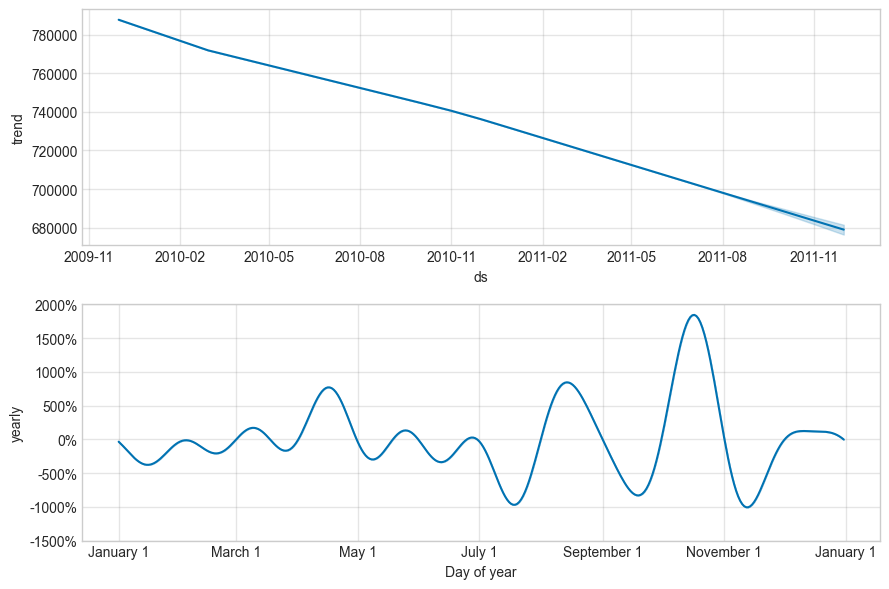


Plot saved: outputs/forecasting/prophet_components.png


In [15]:
# =============================================================================
# CELL 14: PROPHET COMPONENTS
# =============================================================================

print("=" * 60)
print("PROPHET COMPONENTS ANALYSIS")
print("=" * 60)

# Plot components
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.savefig('../outputs/forecasting/prophet_components.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/prophet_components.png")

MODEL COMPARISON

Model Performance Comparison:


,Model,MAE,RMSE,MAPE (%)
0,"ARIMA(0, 1, 0)",294498.431800,355988.003081,30.033105
1,Prophet,186412.389277,214348.065837,22.081494



Best Performing Model: Prophet (MAPE: 22.08%)


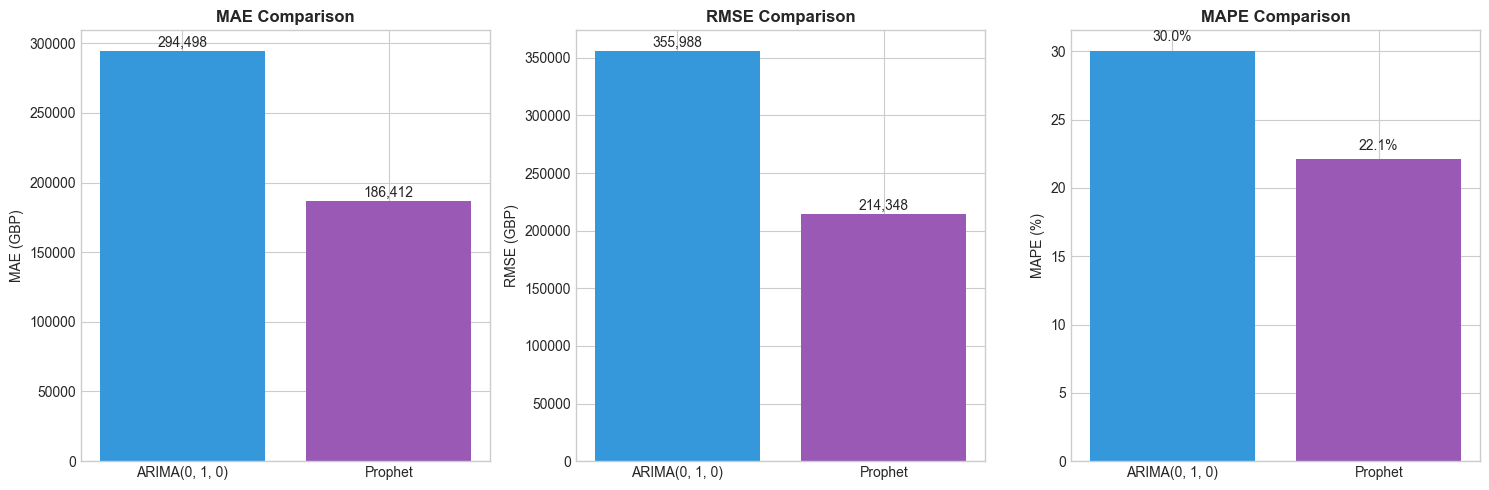


Plot saved: outputs/forecasting/model_comparison.png


In [16]:
# =============================================================================
# CELL 15: MODEL COMPARISON
# =============================================================================

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['ARIMA' + str(best_order), 'Prophet'],
    'MAE': [arima_mae, prophet_mae],
    'RMSE': [arima_rmse, prophet_rmse],
    'MAPE (%)': [arima_mape, prophet_mape]
})

print("\nModel Performance Comparison:")
display(comparison_df)

# Determine best model
if arima_mape < prophet_mape:
    best_model = 'ARIMA'
    best_model_mape = arima_mape
else:
    best_model = 'Prophet'
    best_model_mape = prophet_mape

print(f"\nBest Performing Model: {best_model} (MAPE: {best_model_mape:.2f}%)")

# Visualization comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE comparison
ax1 = axes[0]
bars1 = ax1.bar(comparison_df['Model'], comparison_df['MAE'], color=['#3498db', '#9b59b6'])
ax1.set_title('MAE Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('MAE (GBP)')
for bar, val in zip(bars1, comparison_df['MAE']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{val:,.0f}', ha='center', va='bottom', fontsize=10)

# RMSE comparison
ax2 = axes[1]
bars2 = ax2.bar(comparison_df['Model'], comparison_df['RMSE'], color=['#3498db', '#9b59b6'])
ax2.set_title('RMSE Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (GBP)')
for bar, val in zip(bars2, comparison_df['RMSE']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{val:,.0f}', ha='center', va='bottom', fontsize=10)

# MAPE comparison
ax3 = axes[2]
bars3 = ax3.bar(comparison_df['Model'], comparison_df['MAPE (%)'], color=['#3498db', '#9b59b6'])
ax3.set_title('MAPE Comparison', fontsize=12, fontweight='bold')
ax3.set_ylabel('MAPE (%)')
for bar, val in zip(bars3, comparison_df['MAPE (%)']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/forecasting/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/model_comparison.png")

COMBINED FORECAST VISUALIZATION


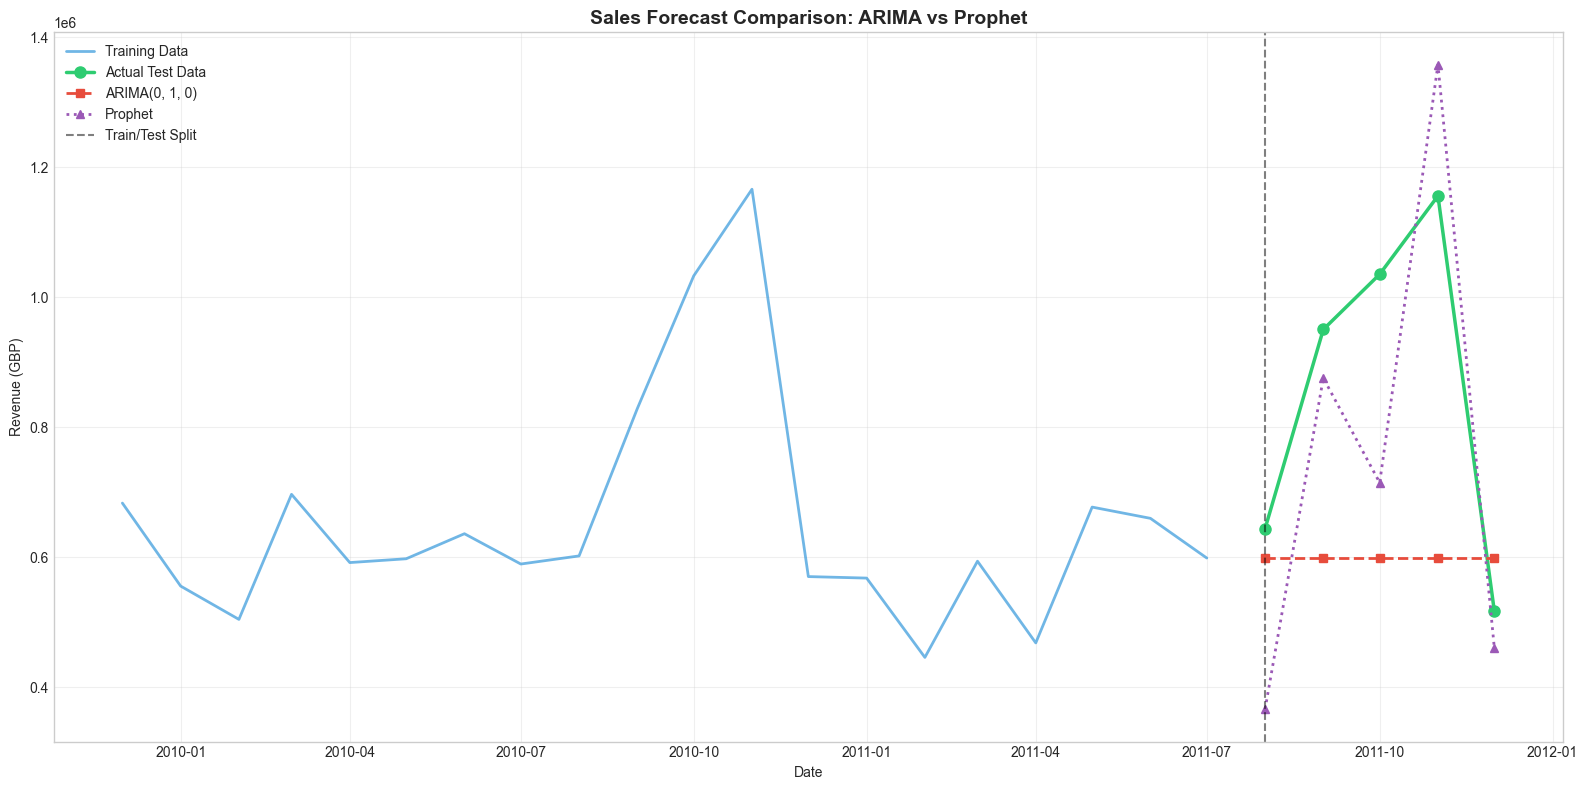


Plot saved: outputs/forecasting/combined_forecast.png


In [17]:
# =============================================================================
# CELL 16: COMBINED FORECAST VISUALIZATION
# =============================================================================

print("=" * 60)
print("COMBINED FORECAST VISUALIZATION")
print("=" * 60)

fig, ax = plt.subplots(figsize=(16, 8))

# Training data
ax.plot(train.index, train['Revenue'], color='#3498db', 
        label='Training Data', linewidth=2, alpha=0.7)

# Actual test data
ax.plot(test.index, test['Revenue'], color='#2ecc71', 
        label='Actual Test Data', linewidth=2.5, marker='o', markersize=8)

# ARIMA predictions
ax.plot(test.index, arima_predictions['Predicted'], color='#e74c3c', 
        label=f'ARIMA{best_order}', linewidth=2, linestyle='--', marker='s', markersize=6)

# Prophet predictions
ax.plot(prophet_predictions['Date'], prophet_predictions['Predicted'], 
        color='#9b59b6', label='Prophet', linewidth=2, linestyle=':', marker='^', markersize=6)

ax.axvline(x=test.index[0], color='black', linestyle='--', alpha=0.5, label='Train/Test Split')

ax.set_title('Sales Forecast Comparison: ARIMA vs Prophet', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (GBP)')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/forecasting/combined_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/combined_forecast.png")

13:16:46 - cmdstanpy - INFO - Chain [1] start processing


FUTURE FORECAST - NEXT 6 MONTHS


13:16:46 - cmdstanpy - INFO - Chain [1] done processing



Future 6-Month Forecast:


,Month,ARIMA_Forecast,ARIMA_Lower,ARIMA_Upper,Prophet_Forecast,Prophet_Lower,Prophet_Upper,Ensemble_Forecast
0,2012-01-01,517208.44,94401.433600,9.400154e+05,656828.164295,649224.313748,664431.855498,587018.302148
1,2012-02-01,517208.44,-80730.962717,1.115148e+06,440305.228862,432089.276265,448509.924020,478756.834431
2,2012-03-01,517208.44,-215114.776880,1.249532e+06,657703.364987,646375.431005,669677.647503,587455.902493
3,2012-04-01,517208.44,-328405.572799,1.362822e+06,681520.462446,664697.678883,698476.686946,599364.451223
4,2012-05-01,517208.44,-428216.767673,1.462634e+06,367839.840444,354246.620251,382408.669596,442524.140222
5,2012-06-01,517208.44,-518452.985353,1.552870e+06,560034.226176,534143.041508,584872.939054,538621.333088


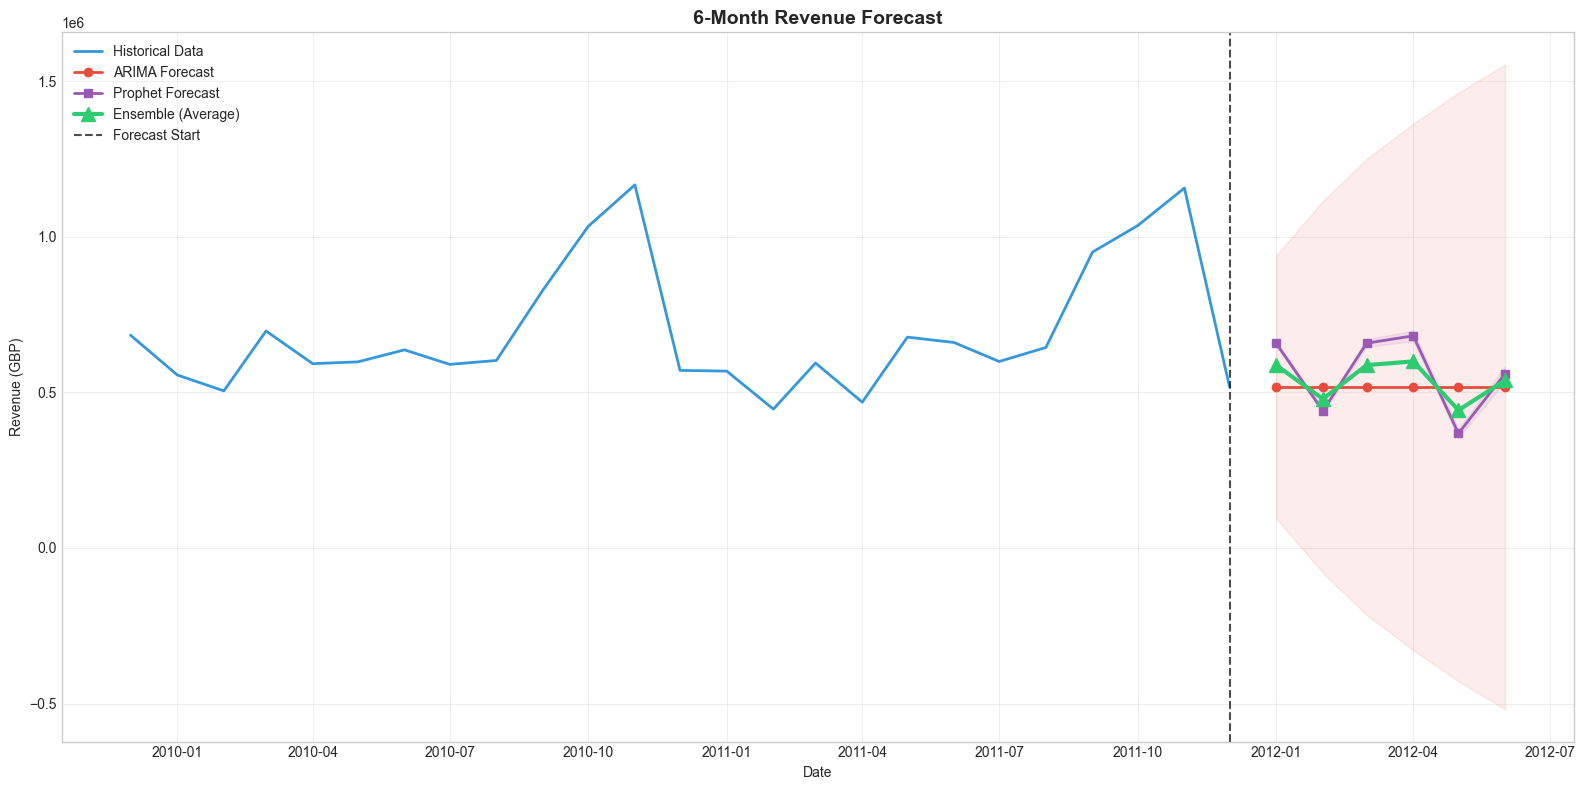


Plot saved: outputs/forecasting/future_forecast.png


In [18]:
# =============================================================================
# CELL 17: FUTURE FORECAST (NEXT 6 MONTHS)
# =============================================================================

print("=" * 60)
print("FUTURE FORECAST - NEXT 6 MONTHS")
print("=" * 60)

# Refit models on full data
full_data = monthly_sales['Revenue']

# ARIMA on full data
arima_full = ARIMA(full_data, order=best_order)
arima_full_fitted = arima_full.fit()

# Forecast next 6 months
forecast_months = 6
arima_future = arima_full_fitted.forecast(steps=forecast_months)
arima_future_conf = arima_full_fitted.get_forecast(steps=forecast_months).conf_int()

# Prophet on full data
prophet_full_data = monthly_sales.reset_index()
prophet_full_data.columns = ['ds', 'y', 'Quantity', 'Transactions']
prophet_full_data = prophet_full_data[['ds', 'y']]

prophet_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
prophet_full.fit(prophet_full_data)

# Future dates
future_dates = prophet_full.make_future_dataframe(periods=forecast_months, freq='MS')
prophet_future = prophet_full.predict(future_dates)
prophet_future_forecast = prophet_future.tail(forecast_months)

# Create future forecast dataframe
last_date = monthly_sales.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                              periods=forecast_months, freq='MS')

future_forecast_df = pd.DataFrame({
    'Month': future_index,
    'ARIMA_Forecast': arima_future.values,
    'ARIMA_Lower': arima_future_conf.iloc[:, 0].values,
    'ARIMA_Upper': arima_future_conf.iloc[:, 1].values,
    'Prophet_Forecast': prophet_future_forecast['yhat'].values,
    'Prophet_Lower': prophet_future_forecast['yhat_lower'].values,
    'Prophet_Upper': prophet_future_forecast['yhat_upper'].values
})

# Ensemble forecast (average of both models)
future_forecast_df['Ensemble_Forecast'] = (
    future_forecast_df['ARIMA_Forecast'] + future_forecast_df['Prophet_Forecast']
) / 2

print("\nFuture 6-Month Forecast:")
display(future_forecast_df)

# Visualize future forecast
fig, ax = plt.subplots(figsize=(16, 8))

# Historical data
ax.plot(monthly_sales.index, monthly_sales['Revenue'], color='#3498db', 
        label='Historical Data', linewidth=2)

# ARIMA future forecast
ax.plot(future_forecast_df['Month'], future_forecast_df['ARIMA_Forecast'], 
        color='#e74c3c', label='ARIMA Forecast', linewidth=2, marker='o')
ax.fill_between(future_forecast_df['Month'],
                future_forecast_df['ARIMA_Lower'],
                future_forecast_df['ARIMA_Upper'],
                color='#e74c3c', alpha=0.1)

# Prophet future forecast
ax.plot(future_forecast_df['Month'], future_forecast_df['Prophet_Forecast'], 
        color='#9b59b6', label='Prophet Forecast', linewidth=2, marker='s')
ax.fill_between(future_forecast_df['Month'],
                future_forecast_df['Prophet_Lower'],
                future_forecast_df['Prophet_Upper'],
                color='#9b59b6', alpha=0.1)

# Ensemble forecast
ax.plot(future_forecast_df['Month'], future_forecast_df['Ensemble_Forecast'], 
        color='#2ecc71', label='Ensemble (Average)', linewidth=3, marker='^', markersize=10)

ax.axvline(x=monthly_sales.index[-1], color='black', linestyle='--', 
           label='Forecast Start', alpha=0.7)

ax.set_title('6-Month Revenue Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (GBP)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/forecasting/future_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/forecasting/future_forecast.png")

In [19]:
# =============================================================================
# CELL 18: SAVE OUTPUTS FOR POWER BI
# =============================================================================

print("=" * 60)
print("SAVING OUTPUTS FOR POWER BI")
print("=" * 60)

# 1. Historical and forecast data combined
historical_df = monthly_sales.reset_index()
historical_df.columns = ['Month', 'Revenue', 'Quantity', 'Transactions']
historical_df['Type'] = 'Actual'
historical_df['ARIMA_Forecast'] = None
historical_df['Prophet_Forecast'] = None
historical_df['Ensemble_Forecast'] = None

future_df = future_forecast_df.copy()
future_df['Revenue'] = None
future_df['Quantity'] = None
future_df['Transactions'] = None
future_df['Type'] = 'Forecast'
future_df = future_df.rename(columns={'Month': 'Month'})

# Select matching columns
cols = ['Month', 'Revenue', 'Type', 'ARIMA_Forecast', 'Prophet_Forecast', 'Ensemble_Forecast']
historical_df = historical_df[cols]
future_df = future_df[cols]

forecast_for_pbi = pd.concat([historical_df, future_df], ignore_index=True)
forecast_for_pbi.to_csv('../outputs/powerbi/forecast_for_pbi.csv', index=False)
print("Saved: outputs/powerbi/forecast_for_pbi.csv")

# 2. Model metrics
metrics_df = comparison_df.copy()
metrics_df.to_csv('../outputs/forecasting/forecast_metrics.csv', index=False)
print("Saved: outputs/forecasting/forecast_metrics.csv")

# 3. Detailed predictions
arima_predictions.to_csv('../outputs/forecasting/arima_predictions.csv', index=False)
print("Saved: outputs/forecasting/arima_predictions.csv")

prophet_predictions.to_csv('../outputs/forecasting/prophet_predictions.csv', index=False)
print("Saved: outputs/forecasting/prophet_predictions.csv")

# 4. Future forecast
future_forecast_df.to_csv('../outputs/forecasting/future_forecast.csv', index=False)
print("Saved: outputs/forecasting/future_forecast.csv")

print("\nAll forecast outputs saved successfully")

SAVING OUTPUTS FOR POWER BI
Saved: outputs/powerbi/forecast_for_pbi.csv
Saved: outputs/forecasting/forecast_metrics.csv
Saved: outputs/forecasting/arima_predictions.csv
Saved: outputs/forecasting/prophet_predictions.csv
Saved: outputs/forecasting/future_forecast.csv

All forecast outputs saved successfully


In [20]:
# =============================================================================
# CELL 19: SUMMARY REPORT
# =============================================================================

print("=" * 70)
print("NOTEBOOK 03 - SALES FORECASTING SUMMARY REPORT")
print("=" * 70)

report = f"""
-----------------------------------------------------------------------------
                     SALES FORECASTING SUMMARY
-----------------------------------------------------------------------------

DATA OVERVIEW
-----------------------------------------
Training Period:         {train.index.min().strftime('%Y-%m')} to {train.index.max().strftime('%Y-%m')}
Test Period:             {test.index.min().strftime('%Y-%m')} to {test.index.max().strftime('%Y-%m')}
Forecast Period:         {future_index[0].strftime('%Y-%m')} to {future_index[-1].strftime('%Y-%m')}

ARIMA MODEL
-----------------------------------------
Best Order:              {best_order}
AIC:                     {best_aic:.2f}
MAE:                     {arima_mae:,.2f} GBP
RMSE:                    {arima_rmse:,.2f} GBP
MAPE:                    {arima_mape:.2f}%

PROPHET MODEL
-----------------------------------------
Seasonality Mode:        Multiplicative
Yearly Seasonality:      Enabled
MAE:                     {prophet_mae:,.2f} GBP
RMSE:                    {prophet_rmse:,.2f} GBP
MAPE:                    {prophet_mape:.2f}%

BEST MODEL
-----------------------------------------
Winner:                  {best_model}
MAPE:                    {best_model_mape:.2f}%

6-MONTH FORECAST SUMMARY
-----------------------------------------
Month           ARIMA         Prophet       Ensemble
"""

for _, row in future_forecast_df.iterrows():
    report += f"{row['Month'].strftime('%Y-%m')}      {row['ARIMA_Forecast']:>12,.0f}  {row['Prophet_Forecast']:>12,.0f}  {row['Ensemble_Forecast']:>12,.0f}\n"

report += f"""
TOTAL           {future_forecast_df['ARIMA_Forecast'].sum():>12,.0f}  {future_forecast_df['Prophet_Forecast'].sum():>12,.0f}  {future_forecast_df['Ensemble_Forecast'].sum():>12,.0f}

FILES GENERATED
-----------------------------------------
Models:
  - arima_model.pkl
  - prophet_model.pkl

Outputs:
  - time_series_overview.png
  - seasonal_decomposition.png
  - differencing.png
  - acf_pacf.png
  - train_test_split.png
  - arima_forecast.png
  - prophet_forecast.png
  - prophet_components.png
  - model_comparison.png
  - combined_forecast.png
  - future_forecast.png

CSV Files:
  - forecast_metrics.csv
  - arima_predictions.csv
  - prophet_predictions.csv
  - future_forecast.csv
  - forecast_for_pbi.csv

-----------------------------------------------------------------------------
READY FOR NOTEBOOK 04: CUSTOMER SEGMENTATION
-----------------------------------------------------------------------------
"""

print(report)

NOTEBOOK 03 - SALES FORECASTING SUMMARY REPORT

-----------------------------------------------------------------------------
                     SALES FORECASTING SUMMARY
-----------------------------------------------------------------------------

DATA OVERVIEW
-----------------------------------------
Training Period:         2009-12 to 2011-07
Test Period:             2011-08 to 2011-12
Forecast Period:         2012-01 to 2012-06

ARIMA MODEL
-----------------------------------------
Best Order:              (0, 1, 0)
AIC:                     516.43
MAE:                     294,498.43 GBP
RMSE:                    355,988.00 GBP
MAPE:                    30.03%

PROPHET MODEL
-----------------------------------------
Seasonality Mode:        Multiplicative
Yearly Seasonality:      Enabled
MAE:                     186,412.39 GBP
RMSE:                    214,348.07 GBP
MAPE:                    22.08%

BEST MODEL
-----------------------------------------
Winner:                  Proph